In [1]:
#| default_exp interface



In [2]:
#| export
import os, sys, warnings
import datetime

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utilities.ipynb_docgen import ( show, DataFrameWrapper, ipynb_doc, capture_hide, capture, monospace)
from utilities.catalogs import (UWcat, Fermi4FGL)
from wtlike import (WtLike, PointSource, SourceFinder, Config)
from astropy.coordinates import SkyCoord

In [3]:
#| export


"""
Analysis of the time behaviour of a source

To run an individual source: examine_source(name)
where name can be:
* any source identifier recognized by SIMBAD
* the name of a uw source in uw1410, specifically in the wtlike table of weights
* a "j-name": format J1234+5678 or J1234.5-6789
"""
_uwname='uw1410'
plt.rc('font', size=12)

def _float_format(f):
    if f==0: return '0'
    return f'{f:.3f}' if (abs(f)>1e-3 and abs(f)<1e5 ) else f'{f:.2e}'

pd.set_option('display.float_format', _float_format)

with capture_hide(f'Catalog setup: {_uwname} and 4FGL-DR3') as catalog_setup:
    if os.environ.get('FERMI', None) is None:
        os.environ['FERMI'] ='.'
        print(f'Setting env var FERMI to ".". Expect to find folders catatag and skymodels')
    cat4 = Fermi4FGL()
    uwcat = UWcat(_uwname)

_sk = uwcat.skycoord.galactic
uwcat.loc[:,'glat'] = _sk.b.deg
uwcat.loc[:,'glon'] = _sk.l.deg
uwcat.loc[:, 'r95'] = np.sqrt( (uwcat.a * 2.64)**2 + (0.00791)**2) # 

src_finder = SourceFinder()

defaults = dict(neighbor=None, interval=30, nyquist=24, max_sep=0.5, tsmin=16, info_name='Other info',
            fft_query='p1>25 & 10>f>0.01', UTC=False)


In [4]:
#| code-fold: true

show(catalog_setup)
show('* Defaults')
show(pd.Series(defaults), index=False)

<utilities.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f37f3fa4940>

* Defaults

neighbor,interval,nyquist,max_sep,tsmin,info_name,fft_query
None,30,24,0.500,16,Other info,p1>25 & 10>f>0.01


In [5]:
#| export

class Summarize():
    """ base class for call-back class"""

    def add(self, sa): 
        pass

class SourceAnalyzer():

    def __init__(self, name, 
            config=None,
            neighbor=None,  
            make_figs=True,
            summarizer=Summarize(),
            **kwargs):
        """
        """
        self.config = config if config is not None else Config()
        self.log=''
        self.wtl=None
        self.max_sep = kwargs.pop('max_sep', defaults['max_sep'])
        self.porb = float(kwargs.pop('porb', np.nan))
        self.fluxlim = kwargs.pop('fluxlim', None)
        interval = kwargs.pop('interval', defaults['interval'])
        nyquist  = kwargs.pop('nyquist', defaults['nyquist'])
        tsmin    = kwargs.pop('tsmin', defaults['tsmin'])
                              
        self.kwargs = kwargs 
        self.fig = None
        assert isinstance(summarizer, Summarize), f'Expect {summarizer} to be subclass of Summarize'
        
         
        SourceFinder.max_sep = self.max_sep #klugy
        if not self.setup(name, neighbor, interval, nyquist, tsmin): 
            return
        if make_figs:
            self.make_plots()
        try:
            summarizer.add(self)
        except Exception as msg:
            print(f"""SourceAnalyzer caught {summarizer.__class__.__name__}
            failure with source {self.name}: {msg} """, file=sys.stderr) 

    def plot_lc(self, ax1=None,ax2=None):
        if self.wtl is  None: return

        if ax1 is None:
            # OK: make figure with 2 subplots
            fig = plt.figure(figsize=(12,2.5))
            gs = plt.GridSpec(1, 2,  width_ratios=[4,1], wspace=0.2,hspace=0.5, top=0.95)
            (ax1,ax2) =  [fig.add_subplot(g) for g in gs]
        else: fig=None
        self.plot_bb(ax1)        
        self.plot_seds(ax2, self.max_sep)
        return fig

    def make_plots(self):

        if self.wtl is not None:
            self.fig=plt.figure(figsize=(12,5))
            gs = plt.GridSpec(2, 2,  width_ratios=[4,1], wspace=0.2,hspace=0.5, top=0.95)
            (ax1,ax2,ax3,ax4) =  [self.fig.add_subplot(g) for g in gs]
            self.plot_lc(ax1=ax1, ax2=ax2)
            self.plot_FFT(ax1=ax3, ax2=ax4)
        else:
            # no analysis since low TS. Only make the sed plots
            self.fig, ax = plt.subplots(figsize=(3,3))
            self.plot_seds(ax, self.max_sep)
        
    def __repr__(self):
        return f'{self.__class__.__name__}("{self.name}")'

    def setup(self, name, neighbor, interval, nyquist, tsmin, **kwargs):
        tstart = self.kwargs.get('tstart',0)
        tstop = self.kwargs.get('tstop',0)
        pt_name = self.pt_name =  src_finder.find(name, tol=self.max_sep)
        if pt_name is None: 
            self.log =  f'<font color="red">Failed lookup:</font> <br>{monospace(src_finder.log)} ' 
            #raise Exception(self.log)
            self.printout=''
            self.name='(not found)'
            self.skycoord = None
            return False
        self.skycoord = src_finder.skycoord
        self.name = name

        with capture_hide(f'Analysis printout for {name} ({pt_name})') as self.printout:
            print(src_finder.log)
            if pt_name not in uwcat.index:
                print(f'UW source {pt_name} not found in {uwname}??')
                self.wtl = self.bb=self.px = None
                self.pointlike_info = FileNotFoundError
                return False
            self.pointlike_info = pi = uwcat.loc[pt_name]
            ts = pi.ts
            if ts < tsmin:
                self.log = f'UW source has TS={ts:.1f} < {tsmin}'
                self.wtl = None
                return True

            self.wtl = WtLike(PointSource(pt_name, config=self.config), time_bins=(tstart, tstop, interval),) 

            if type(neighbor)==str and str(neighbor).strip():
                print(f'Reweighting with {neighbor}')
                self.neighbor_bb = WtLike(neighbor, config=self.config).bb_view()
                self.wtl = self.wtl.reweighted_view(self.neighbor_bb)
            self.bb = self.wtl.view(interval).bb_view()
            
            self.px = self.wtl.periodogram( 1/(4*nyquist), tstart=tstart, tstop=tstop)

            if not(np.isnan(self.porb)) and self.porb is not None:
                # generate orbial phase view to plot later (no periastron yet)
                bins = self.kwargs.get('phase_bins', 8)
                # create a phase view
                self.orbital_phase = self.wtl.phase_view(period=self.porb, nbins=bins)
                phase_df= self.orbital_phase.fits.query('t<1')
                self.orbital_ts = -2 * np.sum([f(1) for f in phase_df.fit.values])
        return True

    def get_catalog_info(self, cat, select=None, show=False):
        """
        select - list of column names
        """
        cone_size = SourceFinder.max_sep
        info = cat.catalog_entry( self.skycoord, cone_size=cone_size)
        if info is None:
            return f'No {cat.name} source within {cone_size} deg'
        name = info.name
        if select is not None:
            info = info[select]

        sep, r95 = info.sep, info.r95
        color = 'red' if sep>r95 else ''
        with capture(
                f'{cat.name} ({name}) <font color={color}>(sep, r95 ={sep*60:.1f}, {r95*60:.1f} arcmin )</font>',
                show=show) as out:
            print(info)
        return out

    def display_4fgl_info(self):
        try:
            return self.get_catalog_info(cat4,
            'fk5 galactic specfunc pivot eflux significance flags variability assoc_prob class1 assoc1_name  r95 sep'.split() )
        except:
            return 'No 4FGL-DR3 info'

    def display_pointlike_info(self):
        if self.pt_name is None:
            return ''
        if self.pt_name not in uwcat.index:
            return f'<font color="red"> Source {self.pt_name} not in {uwname}</font>'
        
        return self.get_catalog_info(uwcat,
            select='jname fk5 galactic specfunc e0 eflux100 ts fitqual locqual aprob r95  sep'.split(),
            )

    def _repr_html_(self):
        if self.fig is None:
            self.fig = make_plots()
            return FigureWrapper(self.fig)._repr_html_()
        return self.printout

    def plot_seds(self, ax=None, cone_size=0.5, **kwargs):
        _, ax = plt.subplots(figsize=(4,4)) if ax is None else (ax.figure, ax)
        c4entry = cat4.catalog_entry(self.skycoord, cone_size=cone_size)
        uwentry = uwcat.catalog_entry(self.skycoord, cone_size=cone_size)

        if uwentry is not None:
            uwentry.specfunc.sed_plot(ax=ax, e0=uwentry.e0, label=uwcat.name)
        if c4entry is not None:
            c4entry.specfunc.sed_plot(ax=ax, e0=c4entry.pivot, label=cat4.name)
            
        kw = dict( yticks=[0.1,1,10], xticks=[0.1,1,10],
            yticklabels='0.1 1 10'.split(), xticklabels='0.1 1 10'.split(),
                ylabel=r'$E^2\ dN/dE\ \mathrm{(eV\ cm^{-2}\ s^{-1})}$')
        kw.update(kwargs)
        ax.set(**kw)

    def get_harmonics(self, f0=None, p='p1', num=10):
        """ Return a DF with the num harmoics of f0
        """
        def htest(p):
            h = np.cumsum(p)-4*np.arange(len(p))
            if len(h)==0:
                return h, -1
            return h, np.argmax(h)
        
        f0 = 1/self.porb if f0 is None else f0
        pdf = self.px.power_df
        f= pdf.f.values
        fmax = f[-1]; imax= len(f)
        deltaf = fmax/imax
        if0 = int(f0/deltaf);  #index of fundamental
        nmax = imax//if0 # harmonic limit 
        # ret = np.full(num, np.nan)
        harmonics =  pdf.iloc[ if0 * np.arange(1, min(num+1, nmax))][p].values 
        h, imax = htest(harmonics)
        self.htest=h[imax] if imax>=0 else np.nan
        return harmonics, h, imax
    
    def get_bb_info(self):
        """ Return BB interval likelihood fits with 2-d (beta-free) fit also """
        
        def g2fit(cell):
            from wtlike.poisson import Poisson
            from wtlike.loglike import LogLike, Gaussian2dRep

            ts = Poisson.from_function(LogLike(cell)).ts
            r = dict(t=cell.t, tw=cell.tw, ts=round(ts,1))            
            if ts<4:
                r.update(flux=0, counts=cell.n, beta=np.nan, sig_beta=np.nan)
            else:
                r.update(Gaussian2dRep(LogLike(cell)).fit)
            return r
        try:
            df_bb = self.bb.fluxes['t tw ts flux errors'.split()]
            df_beta = pd.DataFrame.from_dict( 
                dict((i, g2fit(cell)) for i,cell in self.bb.cells.iterrows()) ,orient='index')\
                    ['flux beta sig_beta'.split()]
            return pd.concat([df_bb, df_beta], axis=1)

        except Exception as e:
            print(f'SourceAnalyzer: bb 2-d fit failed: {e}', file=sys.stderr)
            return None
        
    def plot_bb(self, ax, UTC=False):
        if self.fluxlim is not None:
            ax.set(ylim=self.fluxlim) ###
        self.bb.plot(ax=ax, source_name=self.wtl.source.name, UTC=UTC)
        self.bb_table = self.get_bb_info()

    def display_bb_table(self):
        """ return (hidden) markdown string"""
        bt = self.bb_table
        if bt is None or len(bt)==0 or not 'beta' in bt : return ''
        test = np.max(bt.beta/bt.sig_beta)
        
        warning_text = f'<font color=red>Check beta:  max beta/sig_beta is {test:.1f}</font>' if test>2 else ''
        # with capture_hide(f'BB fits {warning_text}') as cp:
        #     print(bt)
        # return cp
        dw = DataFrameWrapper(bt, summary=f'{len(bt)} BB fits {warning_text}', index=False)
        return dw._repr_html_()

    def plot_periodogram(self, ax3, ax4):
        
        def hist_peak_power(px, pname='p1', ax=None, xlim=(0,40), thresh=25,  **kwargs):
            """
            """
            p1 = px.find_peaks(pname).query('f>0.1')[pname].clip(*xlim)
            fig, ax = plt.subplots(figsize=(3,2)) if ax is None else (ax.figure, ax)
            kw = dict(xlabel=f'Power {pname}', xlim=xlim, title='' )
            kw.update(kwargs); ax.set(**kw)
            ax.hist(p1, np.linspace(*xlim,), log=True, histtype='step', lw=2);
            ax.hist(p1[p1>thresh], np.linspace(*xlim,), log=True, histtype='stepfilled', color='red');
            ax.grid(alpha=0.5)
            return fig
        # self.px = self.wtl.periodogram( 1/(4*nyquist) )
        self.px.power_plot(ax=ax3, pmax=50)
        hist_peak_power(self.px, ax=ax4, title='Peak distribution', xlabel='')

    def get_fft_peaks(self):
        if not hasattr(self, 'px'):
            return pd.DataFrame()
        query = defaults['fft_query']
        df = self.px.find_peaks('p1').query(query).copy()
        if len(df)>0: 
            df['period'] = 1/df.f
        return df
    
    def display_fft_peaks(self, show=False):
        try:
            df = self.get_fft_peaks()
        except:
            return monospace('FFt failed')
        query = defaults['fft_query']
        if len(df)==0:
            return monospace(f'No FFT peaks satisfying {query}')
   
        with pd.option_context('display.precision', 6, 'display.float_format',None):
            dw = DataFrameWrapper(df,
                    summary=f'{len(df)} FFT peaks satisfying {query}: max(p1)={max(df.p1):.1f}',
                    index=False, show=show)
            return dw._repr_html_()

    def get_nearby(self, radius_cut=3, var_cut=30):
        near_df = cat4.select_cone(self.skycoord, cone_size=5, query=f'variability>{var_cut}& sep<{radius_cut}')
        near_df['name'] = near_df.index
        return near_df['sep glon glat significance variability'.split()].sort_values('sep')

    def display_nearby(self, show=False, radius_cut=3, **kwargs):
        near_df = self.get_nearby(radius_cut=radius_cut, **kwargs)
        if len(near_df)==0: return f' No nearby (within {radius_cut} deg) variable sources.'
        dw = DataFrameWrapper(near_df,
            summary=f'{len(near_df) } nearby variable sources'
            )
        return dw._repr_html_()
        # with capture(f'{len(near_df) } nearby variable sources', show=show) as out:
        #     print(near_df)
        # return out

    def plot_FFT(self, ax1=None, ax2=None, peak_query='f>0.01'):
        """ Generate a Kerr Periodogram and a histogram of the peak values
        
        px -- TimeSeries object
        
        Return the figure with two Axes plots if had to create
        """
        def hist_peak_power(px, pname='p1', ax=None, xlim=(0,40), thresh=25,  **kwargs):
            """
            """
            p1 = px.find_peaks(pname).query(peak_query)[pname].clip(*xlim)
            _, ax = plt.subplots(figsize=(3,2)) if ax is None else (ax.figure, ax)
            kw = dict(xlabel=f'Power {pname}', xlim=xlim, title='' )
            kw.update(kwargs); ax.set(**kw)
            ax.hist(p1, np.linspace(*xlim,), log=True, histtype='step', lw=2);
            ax.hist(p1[p1>thresh], np.linspace(*xlim,), log=True, histtype='stepfilled', color='red');
            ax.grid(alpha=0.5)
        
        if ax1 is None:
            fig = plt.figure(figsize=(12,2.5))
            gs = plt.GridSpec(1, 2,  width_ratios=[4,1], wspace=0.2,hspace=0.5, top=0.95)
            (ax1,ax2) =  [fig.add_subplot(g) for g in gs]
        else: fig=None

        px = self.px
        px.power_plot(ax=ax1, pmax=50)
        hist_peak_power(px, ax=ax2,  xlabel='')
        ax2.set( xlabel=r'$P_1$ peak values')
        return fig

    def plot_orbital_phase(self, ax=None, **kwargs):
        if self.porb is None:
            print('No orbital period available', file=sys.stderr)
            return
       
        fig,ax = plt.subplots(figsize=(4,2)) if ax is None else (ax.figure, ax)
        kw = dict(xlim=(0,1), xticks=np.arange(0,1.01,0.25)); 
        kw.update(kwargs)
        self.orbital_phase.plot(ax=ax, **kw)
        ax.axvline( 1.0, ls='--', color='lightgrey')
        return fig
        
    def plot_phase(self, ax=None, **kwargs):

        period = kwargs.pop('period', self.porb)
        nbins  = kwargs.pop('nbins', 10)
        ref    = kwargs.pop('ref', '2008')        

        fig,ax = plt.subplots(figsize=(6,3)) if ax is None else (ax.figure, ax)
        kw = dict(xlim=(0,1),ylim=(0,None),); kw.update(kwargs)
        
        self.wtl.phase_view(period=period, nbins=nbins, reference=ref).plot(ax=ax, **kw)
        
        ax.axvline( 1.0, ls='--', color='lightgrey')
        return fig
    
    def plot_harmonics(self, ax=None, num=10, p='p1'):

        # def htest(p):
        #     h = np.cumsum(p)-4*np.arange(len(p))
        #     return h, np.argmax(h)

        fig, ax = plt.subplots(figsize=(4,2)) if ax is None else (ax.figure, ax)
        harmonics, h, imax = self.get_harmonics(num=10)
        x = np.arange(1,len(harmonics)+1)
        ax.plot(x, harmonics, 'o--')
        ax.plot(x,  h, 'D--', color='orange')
        if imax>=0:
            ax.scatter(x[imax], h[imax], marker='*', c='red',s=200)
        t = ax.get_ylim()
        ax.set(xlabel='Harmonic', ylabel='FFT power', ylim=(0, max(14.9,t[1])),
              xticks=range(1,11,2), xlim=(0.5, 10.5), )
        ax.grid(alpha=0.5)
        return fig


In [6]:
#| export
  
class SummaryInfo:  
    """Batch process a list of sources,
        returning a dict of summary info for each one
    """  
    
    def __call__(self, info, config=None):
        if type(info)==str:  name, info = info, {}
        else: name = info.name

        # run the analyzer without making figures
        try:
            sa = SourceAnalyzer(name, make_figs=False, tsmin=20, config=config)
        except Exception as e:
            return name, dict(error=str(e))
        if sa.name=='(not found)':
            return name, dict(error='source name not found')
        if sa is None:
            return name, dict(error='SourceAnalyzer failure')
        
        ret =  dict(
            light_curve = sa.get_bb_info(),
            fft_peaks = sa.get_fft_peaks(),
            nearby = sa.get_nearby(), 
            porb = sa.porb,)
        if not pd.isna(sa.porb):
            # items computed only porb is specified.
            ret.update(
                phase_lc = sa.orbital_phase.fits,
                harmonics = sa.get_harmonics(num=10) 
            )
        return name, ret
    
    def run(self, df):
        if isinstance(df, pd.DataFrame):
            # a data frame: column info passed to the analyzer
            return dict(df.apply(self, axis=1))
        elif hasattr(df, '__len__'):
            # a list of names
            return dict( map( lambda n: (n, self(n)),   df))
        elif type(df)==str:
            # perhas a 
            return self(df)
        else:
            raise Exception(f'Type {type(df)} not recognized')
        
def phase_plots(ldf, ncols=4):
    from wtlike.lightcurve import flux_plot
    nrows=(len(ldf)+ncols-1)//ncols
    fig, axx = plt.subplots(ncols=ncols, nrows=nrows, 
                            figsize=(12,nrows*2.+1), sharex=True)
    plt.subplots_adjust(wspace=0.2, hspace=0.05, top=0.935);
    axf = axx.flatten()
    for (name, info), ax in zip(ldf.items(), axf):
        pip = info['phase_lc']
        flux_plot(pip.iloc[:len(pip)//2], ax=ax, xlim=(0,1), legend_loc='none', 
                 step=True, colors=('cornflowerblue','cornflowerblue','blue'))
        ax.text(0.05,0.95, f'{name}\n{info["porb"]}', 
                transform=ax.transAxes, va='top', fontsize=10)
        t = ax.get_ylim()
        ax.set(ylabel='', xlabel='', ylim=(t[0], t[1]*1.1))
        ax.axhline(1, ls='--', color='grey')
    for ax in axf[len(ldf): len(axf)]: ax.set_visible(False)
    fig.suptitle('HMXB orbital phase plots', fontsize=18)
    return fig   

def harmonic_plots(ldf, ncols=4):
    nrows=(len(ldf)+ncols-1)//ncols
    fig, axx = plt.subplots(ncols=ncols, nrows=nrows, 
                            figsize=(12,nrows*2.+1), sharex=True)
    plt.subplots_adjust(wspace=0.2, hspace=0.1, top=0.935);
    axf = axx.flatten()
    for (name, info), ax in zip(ldf.items(), axf):
        pip, h,imax = info['harmonics']
        x = np.arange(1,len(pip)+1)
        ax.plot(x, pip, 'o--')

        ax.plot(x,  h, 'D--', color='orange')
        if imax>=0:
            ax.scatter(x[imax], h[imax], marker='*', c='red',s=200)
        ax.text(0.04,0.95, f'{name}', transform=ax.transAxes, va='top', fontsize=10)
        ax.text(0.97,0.95, f'{h[imax]:.0f}', 
                transform=ax.transAxes, va='top', ha='right', fontsize=10)
        t = ax.get_ylim()
        ax.set(ylabel='', xlabel='', ylim=(0, max(14.9,t[1]*1.3)),
              xticks=range(1,11,2), xlim=(0.5, 10.5))
        ax.grid(alpha=0.5)

    for ax in axf[len(ldf): len(axf)]: ax.set_visible(False)
    fig.suptitle('HMXB H-test', fontsize=18)
    return fig

In [7]:
#| export

proc = None
def get_SA():
    """ access to the most recent SourceAnalyzer object"""
    return proc

@ipynb_doc
def examine_source(name, info=None, text='',  **kwargs): 

    """### {name}
    {other_info}
    {text}
    {log}
    {printout}
    {neighbor_plot}
    {pinfo}
    {ginfo}
    {fig}
    {nearby}
    {beta}
    {fft_peaks}
    {periodic_plots}
    
    """
    global proc
    ginfo=beta=fig=fft_peaks=nearby=neighbor_plot=pinfo=other_info=phase_plot=''
    kw = defaults.copy() 
    kw.update(kwargs)
    if info is not None: kw.update(info)
    max_sep = kw.pop('max_sep', None)
    info_name = kw.pop('info_name', 'Source info')
    if max_sep is not None: SourceFinder.max_sep=max_sep

    # the additional info, a dict-like object, can update default analysis parameters
    if info is not None:
        for k,v in info.items():
            if k in defaults and str(v)!='nan':
                # print(f'setting {k} from {kw[k]} to {v}')
                kw[k]=v

        with capture_hide(f'{info_name}') as other_info:
            print(info)
    else: other_info=''


    neighbor = kw.get('neighbor',None)
    if not str(neighbor).strip(): neighbor=None
    neighbor_info = '' if type(neighbor)!=str  else f'Reweighted with {neighbor}'
    
    try:
        proc = self = SourceAnalyzer(name, **kw)
    except Exception as ex:
        printout = f'<font color="red">Failed: {ex}</font>\n'
        raise
        return locals()
    
    log = '' if not self.log else f'<font color="red">{self.log}</font>'
    # proc = self = SourceAnalyzer(name, **kw)
    printout=self.printout
    if self.skycoord is None:
        return locals()
    pinfo = self.display_pointlike_info()
    ginfo = self.display_4fgl_info()
    fig = self.fig
    
    nearby = self.display_nearby()

    if self.wtl is not None:
        beta = self.display_bb_table()
        fft_peaks = self.display_fft_peaks()

    if type(neighbor) != str :
        neighbor_plot = ''
    elif self.wtl is not None: 
        neighbor_plot, ax = plt.subplots(figsize=(10,3))
        self.neighbor_bb.plot(ax=ax)
        neighbor_plot.summary= f'Reweighted with {neighbor} (click for its light curve)'

    if getattr(self, 'orbital_phase', None) is not None:
        periodic_plots, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,2.5))

        self.plot_orbital_phase(ax=ax1)
        self.plot_harmonics(ax=ax2)
        periodic_plots.summary =f"""Period {self.porb:.6f} d: TS {self.orbital_ts:.0f} 
        H-test {self.htest:.1f}"""
    else: periodic_plots=''
        

    return locals()

In [8]:
#| export
class PhaseInfo(Summarize):
    
    def __init__(self, df):
        self.df = df        

    def add(self, sa): 
        """Called back from SourceAnalyzer
            Extract porb, the FFT power and phase view fits dataframes 
            into a dict
        """
        self.phasedict = dict(
                    powerdf = sa.px.power_df,
                    phasedf = sa.orbital_phase.fits,
                    porb = sa.porb,
                    )
        
    def __call__(self, idx):
        """ called to process self.df.iloc[idx]
        return (name, dict) tuple
        """
        info = self.df.iloc[idx]
        SourceAnalyzer(info.name, porb=info.porb, 
                    summarizer=self, make_figs=False, tsmin=20)  
        return  (info.name, self.phasedict)
    
    @classmethod
    def multirun(cls, df, poolsize=4, cache_file=None, update=False):
        """Run a set of sources in parallel, using SourceAnalyzer
        df has name and porb 
        """
        from wtlike.config import Timer
        from multiprocessing import Pool
        import pickle
        
        cf = Path(cache_file)
        if cf.is_file() and not update:
            with open(cf, 'rb') as inp:
                ldf =pickle.load(inp)
                show(f'Read cache file {cf} with {len(ldf)} sources')
                return ldf
                     
        N = len(df)
        show(f'### Analyzing {N} sources with {poolsize} processes...')
        t=Timer()
        if poolsize==1:
            ldf = list(map(cls(df), range(N)))
        else:
            with Pool(processes=poolsize) as pool:
                ldf = pool.map(cls(df), range(N)) 
        show(t)
        if cf is not None:
            with open(cf, 'wb') as out:
                pickle.dump(ldf, out)
            show(f'Cache file saved to {cf}')
        return ldf


In [9]:
#| export
def process_df(df, **kwargs): #, max_sep=None, tsmin=50):

    defaults.update(kwargs)
    with capture('Default parameter values') as parout:
        print(pd.Series(defaults))

    show(f"""\
        ## Processing {len(df)} sources, start {str(datetime.datetime.now())[:16]}
        {parout}
        
        ---
        """)
    for name, info in df.iterrows():
        if type(name) !=str:
            print(f'Bad entry: {name}', file=sys.stderr)
            continue
        examine_source(name, info=info, **kwargs ) 

    show(f"""\
    
        \n---
        \n## Finish at {str(datetime.datetime.now())[:16]}""")

class WTSkyCoord(SkyCoord):
    def __repr__(self):
        ra,dec = self.fk5.ra.deg, self.fk5.dec.deg
        return f'({ra:7.3f},{dec:+7.3f})'


def load_source_spreadsheet(
            filename='AMXP scorecard (2).xlsx',
            source_name='AMXP name',
            ra_name=None, dec_name=None,
            flag_row=True):
    """Return a dataframe derived from the table in a spreadsheet
    row 1 is column names
    if flag_row is True row 2 has non-blank to include the column in the datafrane
    if ra_name (and dec_name) are not None, rename columns to "ra" and "dec"
    The index is set to the contents of source_nane
    """
    spreadsheet = Path(filename) #'AMXP scorecard (2).xlsx')
    assert spreadsheet.is_file(), f'File "{filename}" not found'
    df = pd.read_excel(spreadsheet)
    assert source_name in df.columns, f'did not find column "{source_name}" to use as index'
    # take care of trailing non-break space
    df.index = list(map(lambda s:str(s).strip().replace(u"\u2014","-"),df.loc[:,source_name]))
    if flag_row:
        to_drop = pd.isna(df.iloc[0])
        to_drop[source_name]=True
        df = df.drop(columns=df.columns[to_drop])[1:]
    else:
        df = df.drop(columns=[source_name])
    if ra_name is not None:
        df.rename(columns={ra_name: 'ra', dec_name: 'dec'}, inplace=True)
    return df

def get_fermi_info(source_names, max_sep=0.5):
    """
    Return a dataframe with information on UW and 4FGL sources near the locations of a list of source names
    """
    
    src_finder = SourceFinder()
    SourceFinder.max_sep = max_sep
    
    class SourceInfo(dict):

        class SkyCoord(SkyCoord):
            # subclass that displays (ra,dec)
            def __repr__(self):
                ra,dec = self.fk5.ra.deg, self.fk5.dec.deg
                return f'({ra:6.3f},{dec:+6.3f})'

        def __init__(self, name):
            #self.name=name.replace('_',' ')
            src_finder.log=''

            # get the nearest pointlike name from the weight tables
            self.pt_name = pt_name = src_finder(name) 

            try:
                self['skycoord'] = self.SkyCoord(src_finder.skycoord)
            except ValueError as err:
                print(f'SourceInfo: Fail to recognize name "{name}"', file=sys.stderr)
                return

            if pt_name is None: return

            # grab pointlike info
            uw = self.get_uwinfo(pt_name)
            if len(uw)==0: 
                self.update(uw_name = pt_name) 
                return
            self.update(uw_name=pt_name,
                        uw_pos=self.SkyCoord(uw.ra,uw.dec,unit='deg',frame='fk5'), 
                        uw_sep = uw.sep,
                        uw_r95 = uw.r95,
                        uw_ts = uw.ts,
                        uw_sed= uw.specfunc,
                        uw_jname = uw.jname,
                       )
            dr = self.get_4fgl()
            if len(dr)==0: return
            self.update(dr_name=dr.name,
                        dr_pos=self.SkyCoord(dr.ra,dr.dec,unit='deg', frame='fk5'),
                        dr_sep = dr.sep,
                        dr_r95 = dr.r95,
                        dr_class1=dr.class1)
        def get_uwinfo(self, pt_name):
            #return a dict 
            if pt_name not in uwcat.index:
                # print(f'{self.name}: UW source {pt_name} not found in {uwname}??', file=sys.stderr)
                return pd.Series(name=pt_name, dtype=object)
            info = uwcat.catalog_entry( self['skycoord'], cone_size=SourceFinder.max_sep)
            return pd.Series(info)

        def get_4fgl(self):
            info = cat4.catalog_entry( self['skycoord'], cone_size=SourceFinder.max_sep)
            if info is None: return pd.Series(dtype=object)
            return pd.Series(info)

        def __repr__(self):
            return f'{self.__class__.__name__}({self.name}):\n{pd.Series(self, dtype=object)}'
    
    source_names = np.atleast_1d(source_names)
    return pd.DataFrame([SourceInfo(name) for name in source_names], index=source_names )

In [10]:
#| export
def setup_excel(filename, 
        source_name_column,
        ra_name=None, dec_name=None,
        title='Excel analysis',
        query='',
        select = (None,),
        **kwargs):

    defaults.update(kwargs)

    spreadsheet = Path(filename) #'AMXP scorecard (2).xlsx')
    assert spreadsheet.is_file(), f'File "{filename}" not found'
    if len(title)>1 and title[0] != '#' : title = '# '+title
    show(f"""\
        {title}

        {catalog_setup}
        Read spreadsheet "{spreadsheet.absolute()}", 
        dated {str(datetime.datetime.fromtimestamp(spreadsheet.stat().st_mtime))[:16]}
        """)
    # make the index the source name, remove columns without a "1" (or anything?) in the second row
    df = pd.read_excel(spreadsheet)
    assert source_name_column in df.columns, f'did not find column "{source_name_column}" to use as index'
    df.index = df.loc[:,source_name_column]
    to_drop = pd.isna(df.iloc[0])
    if type(select) != tuple: 
        # assume selecting a single row
        select = (select,select+1)
    df = df.drop(columns=df.columns[to_drop])[1:][slice(*select)]
    if ra_name is not None and dec_name is not None:
        sc = SkyCoord(df[ra_name], df[dec_name], unit='deg', frame='fk5')
        df.loc[:,'skycoord'] = CatDF.SkyCoord(sc)
    if query:        
        df = df.query(query)
    return df

def process_excel(filename, source_name_column,  **kwargs):
    df = setup_excel(filename, source_name_column,  **kwargs)
    return process_df(df, **kwargs)

### PSR J1227-4853



<details  class="nbdoc-description" >  <summary> Analysis printout for PSR J1227-4853 (PSR J1227-4853) </summary>  <div style="margin-left: 25px;"><pre>Source name, "PSR J1227-4853" <br>	Found in pointlike weight tables<br>	corresponds to uw1410 source "PSR J1227-4853".<br>SourceData:  PSR J1227-4853: Restoring from cache with key "PSR J1227-4853_data"<br>SourceData: Source PSR J1227-4853 with:<br>	 data:       191,534 photons from 2008-08-04 to 2023-02-28<br>	 exposure: 3,445,298 intervals,  average effective area 3403 cm^2 for 102.9 Ms<br>	 rates:  source 2.83e-08/s, background 5.19e-07/s, TS 3778.4<br>CellData.rebin: Bin photon data into 177 30-day bins from 54683.0 to 59993.0<br>LightCurve: select 177 cells for fitting with e&gt;150.000 & n&gt;2<br>CellData.rebin: Bin photon data into 177 30-day bins from 54683.0 to 59993.0<br>LightCurve: select 177 cells for fitting with e&gt;150.000 & n&gt;2<br>Bayesian Blocks: partitioning 177 cells using LikelihoodFitness with penalty 5%<br>	found 4 / 177 blocks.<br>LightCurve: Loaded 4 / 4 cells for fitting<br>CellData.rebin: Bin photon data into 510720 15-min bins from 54683.0 to 60003.0<br></pre></div> </details>

<details  class="nbdoc-description" >  <summary> uw1410 (PSR J1227-4853) <font color=>(sep, r95 =0.0, 1.1 arcmin )</font> </summary>  <div style="margin-left: 25px;"><pre>jname                                       J1227.9-4854<br>fk5                                    (186.995,-48.900)<br>galactic                               (298.966,+13.791)<br>specfunc    PLSuperExpCutoff(9.39e-12, 1.98, 3301, 0.67)<br>e0                                               786.008<br>eflux100                                        2.57e-11<br>ts                                              3778.356<br>fitqual                                            7.450<br>locqual                                            0.050<br>aprob                                              1.000<br>r95                                                0.018<br>sep                                             5.90e-06<br>Name: PSR J1227-4853, dtype: object<br></pre></div> </details>
<details  class="nbdoc-description" >  <summary> 4FGL-DR3 (4FGL J1228.0-4853) <font color=>(sep, r95 =1.1, 1.3 arcmin )</font> </summary>  <div style="margin-left: 25px;"><pre>fk5                                         (187.010,-48.885)<br>galactic                                    (298.975,+13.807)<br>specfunc        PLSuperExpCutoff4(1.38e-12, 2.19, 0.32, 0.67)<br>pivot                                                1448.319<br>eflux                                                1.90e-11<br>significance                                           32.527<br>flags                                                     {2}<br>variability                                            57.905<br>assoc_prob                                              1.000<br>class1                                                    MSP<br>assoc1_name                                    PSR J1227-4853<br>r95                                                     0.022<br>sep                                                     0.018<br>Name: 4FGL J1228.0-4853, dtype: object<br></pre></div> </details>
<div style="margin-left: 25px"><figure style="margin-left: 25px" title="Figure 1">   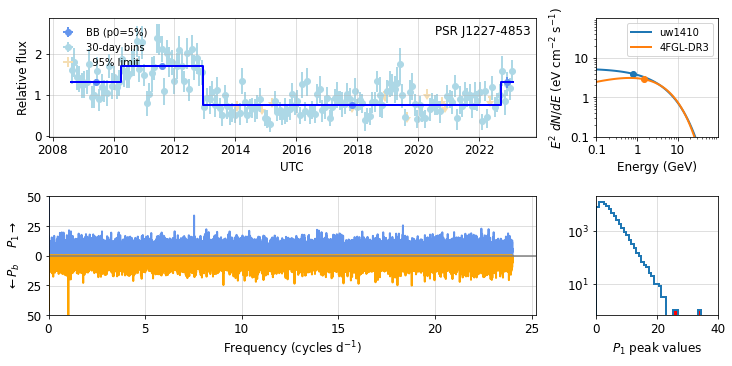 </figure></div>
<details >  <summary> 3 nearby variable sources </summary>  <div style="margin-left: 25px"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>sep</th>
      <th>glon</th>
      <th>glat</th>
      <th>significance</th>
      <th>variability</th>
    </tr>
    <tr>
      <th>name</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>4FGL J1228.0-4853</th>
      <td>0.018</td>
      <td>298.975</td>
      <td>13.807</td>
      <td>32.527</td>
      <td>57.905</td>
    </tr>
    <tr>
      <th>4FGL J1226.8-4907</th>
      <td>0.289</td>
      <td>298.804</td>
      <td>13.548</td>
      <td>7.468</td>
      <td>38.685</td>
    </tr>
    <tr>
      <th>4FGL J1244.2-4956</th>
      <td>2.839</td>
      <td>301.741</td>
      <td>12.911</td>
      <td>10.583</td>
      <td>33.430</td>
    </tr>
  </tbody>
</table></div> </details>
<details >  <summary> 4 BB fits <font color=red>Check beta:  max beta/sig_beta is 2.6</font> </summary>  <div style="margin-left: 25px"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>t</th>
      <th>tw</th>
      <th>ts</th>
      <th>flux</th>
      <th>errors</th>
      <th>flux</th>
      <th>beta</th>
      <th>sig_beta</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>54983.000</td>
      <td>600.000</td>
      <td>663.900</td>
      <td>1.319</td>
      <td>(-6.9e-02, 0.07)</td>
      <td>1.296</td>
      <td>0.006</td>
      <td>0.008</td>
    </tr>
    <tr>
      <td>55778.000</td>
      <td>990.000</td>
      <td>1733.200</td>
      <td>1.696</td>
      <td>(-0.057, 0.057)</td>
      <td>1.699</td>
      <td>-7.19e-04</td>
      <td>0.006</td>
    </tr>
    <tr>
      <td>58058.000</td>
      <td>3570.000</td>
      <td>1782.000</td>
      <td>0.757</td>
      <td>(-0.024, 0.024)</td>
      <td>0.767</td>
      <td>-0.003</td>
      <td>0.003</td>
    </tr>
    <tr>
      <td>59918.000</td>
      <td>150.000</td>
      <td>178.000</td>
      <td>1.303</td>
      <td>(-0.135, 0.136)</td>
      <td>1.147</td>
      <td>0.040</td>
      <td>0.016</td>
    </tr>
  </tbody>
</table></div> </details>
<details >  <summary> 2 FFT peaks satisfying p1>25 & 10>f>0.01: max(p1)=33.9 </summary>  <div style="margin-left: 25px"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>f</th>
      <th>p1</th>
      <th>period</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>7.530045</td>
      <td>26.640545</td>
      <td>0.132801</td>
    </tr>
    <tr>
      <td>7.530309</td>
      <td>33.886688</td>
      <td>0.132797</td>
    </tr>
  </tbody>
</table></div> </details>



In [11]:
#| code-fold: true

examine_source('PSR J1227-4853')

In [12]:
#| include: false
from nbdev import nbdev_export
nbdev_export()
!date

Wed Mar 29 03:45:38 PDT 2023
